<a href="https://colab.research.google.com/github/Nathan-Levy/Traffic-Flow-Prediction-in-Urban-Areas/blob/main/Current_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow import keras
import matplotlib.pyplot as plt

In [ ]:
controller_data_test = pd.read_csv('Combined flows test.csv')
controller_data_test.dropna(how='all', inplace=True)

controller_data_train = pd.read_csv('Combined flows train.csv')
controller_data_train.dropna(how='all', inplace=True)

In [ ]:
controller_data_train["5 Minutes"] = pd.to_datetime(controller_data_train["5 Minutes"])
controller_data_train.set_index("5 Minutes", inplace=True)
train_flow = controller_data_train[['MADOR Flow (Veh/5 Minutes)', 'THIRD Flow (Veh/5 Minutes)', '11TH Flow (Veh/5 Minutes)', 'ADAMS Flow (Veh/5 Minutes)', 'KING BLVD Flow (Veh/5 Minutes)']]


controller_data_test["5 Minutes"] = pd.to_datetime(controller_data_test["5 Minutes"])
controller_data_test.set_index("5 Minutes", inplace=True)
test_flow = controller_data_test[['MADOR Flow (Veh/5 Minutes)', 'THIRD Flow (Veh/5 Minutes)', '11TH Flow (Veh/5 Minutes)', 'ADAMS Flow (Veh/5 Minutes)', 'KING BLVD Flow (Veh/5 Minutes)']]

In [ ]:
# Normalise
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train = scaler.fit_transform(train_flow)
test = scaler.transform(test_flow)

In [ ]:
def create_dataset(dataset, look_back):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), :])
        y.append(dataset[i + look_back, :])
    return np.array(X), np.array(y)

look_back = 12

# [samples, time steps, features]
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

In [ ]:
from keras import layers
input_layer = keras.layers.Input(shape=(look_back, 5))
encoded = keras.layers(400, activation='tanh', return_sequences=True)(input_layer)
encoded = keras.layers.LSTM(400, activation='tanh', return_sequences=False)(encoded)


# Decoder
decoded = keras.layers.RepeatVector(look_back)(encoded)
decoded = keras.layers.LSTM(400, activation='tanh', return_sequences=True)(decoded)
decoded = keras.layers.TimeDistributed(layers.Dense(5, activation='linear'))(decoded)

# Autoencoder Model
autoencoder = keras.models.Model(inputs=input_layer, outputs=decoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 12, 5)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 12, 400)             │         649,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 400)                 │       1,281,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 12, 400)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 12, 400)             │       1,281,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 12, 5)               │           2,005 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,214,805 (12.26 MB)

 Trainable params: 3,214,805 (12.26 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
train = autoencoder.fit(X_train, X_train, epochs=1, validation_data=(X_test, X_test))

567/567 ━━━━━━━━━━━━━━━━━━━━ 223s 383ms/step - loss: 0.0173 - val_loss: 0.0026


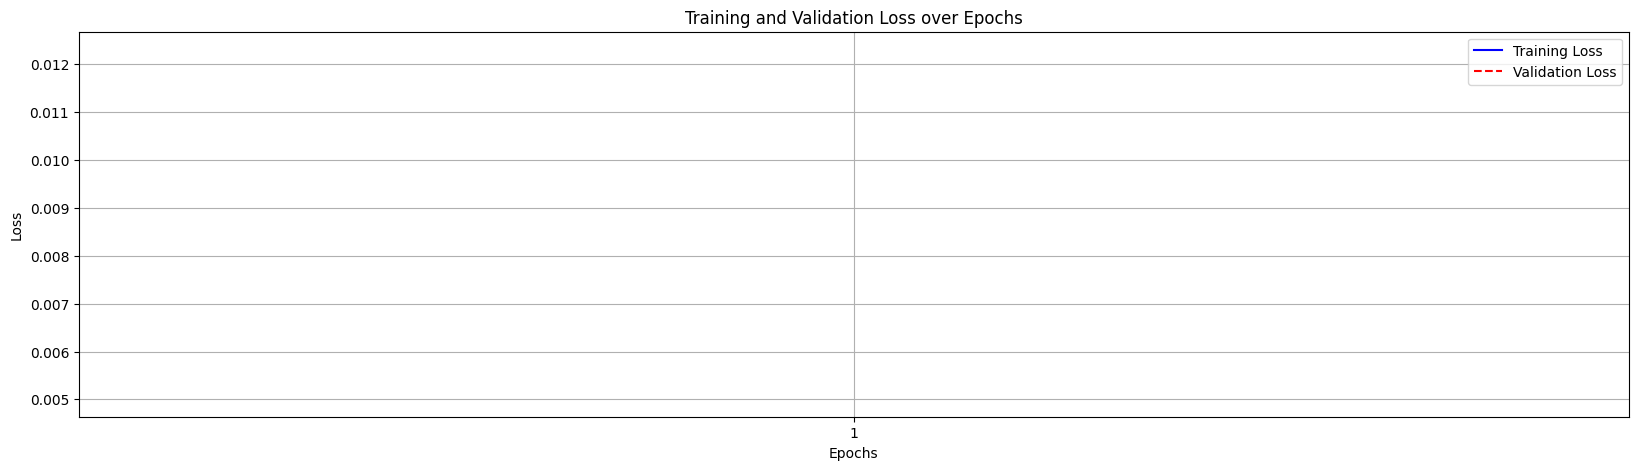

In [ ]:
# Function to plot loss over epochs
def plot_loss(history):
    plt.figure(figsize=(20, 5))
    epochs = range(1, len(history.history['loss']) + 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss', color='blue')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss', color='red', linestyle='dashed')
    plt.xticks(epochs)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(train)

In [ ]:
# Extract the encoder model
encoder = keras.models.Model(inputs=input_layer, outputs=encoded)

# Generate the encoded features
encoded_features = encoder.predict(X_train)
encoded_features_val = encoder.predict(X_test)

567/567 ━━━━━━━━━━━━━━━━━━━━ 29s 51ms/step
252/252 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step


In [ ]:
encoded_features = encoded_features.reshape(encoded_features.shape[0], 1, encoded_features.shape[1])
encoded_features_val = encoded_features_val.reshape(encoded_features_val.shape[0], 1, encoded_features_val.shape[1])

In [ ]:
# Define the prediction model
prediction_model = keras.models.Sequential()
prediction_model.add(keras.layers.LSTM(400, activation='relu', return_sequences=True, input_shape=(1, 400)))
prediction_model.add(keras.layers.LSTM(200, activation='relu', return_sequences=False))
prediction_model.add(keras.layers.Dense(5, activation='linear'))

# Compile the prediction model
prediction_model.compile(optimizer='adam', loss='mse')

# Train the prediction model
prediction_model.fit(encoded_features, y_train, epochs=5, validation_data=(encoded_features_val, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
567/567 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - loss: 0.0390 - val_loss: 0.0040
Epoch 2/5
567/567 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - loss: 0.0028 - val_loss: 0.0040
Epoch 3/5
567/567 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - loss: 0.0027 - val_loss: 0.0042
Epoch 4/5
567/567 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - loss: 0.0027 - val_loss: 0.0040
Epoch 5/5
567/567 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - loss: 0.0026 - val_loss: 0.0036


In [ ]:
# Use the prediction model to make predictions
y_pred = prediction_model.predict(encoded_features_val)

252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [ ]:
# Inverse transform the predictions to the original scale
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

In [ ]:
import numpy as np

# Define evaluation metric functions
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mean_relative_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) / np.abs(y_true))

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# Function to evaluate model performance
def evaluate_model(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mre = mean_relative_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)

    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Relative Error (MRE): {mre:.4%}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Example Usage:
# Replace y_test and y_pred with actual test labels and predictions
# y_test = np.array([...])  # Actual traffic flow values
# y_pred = np.array([...])  # Predicted traffic flow values
evaluate_model(np.array(y_test_rescaled), np.array(y_pred_rescaled))


Mean Absolute Error (MAE): 31.7235
Mean Relative Error (MRE): 9.1707%
Root Mean Squared Error (RMSE): 44.1511


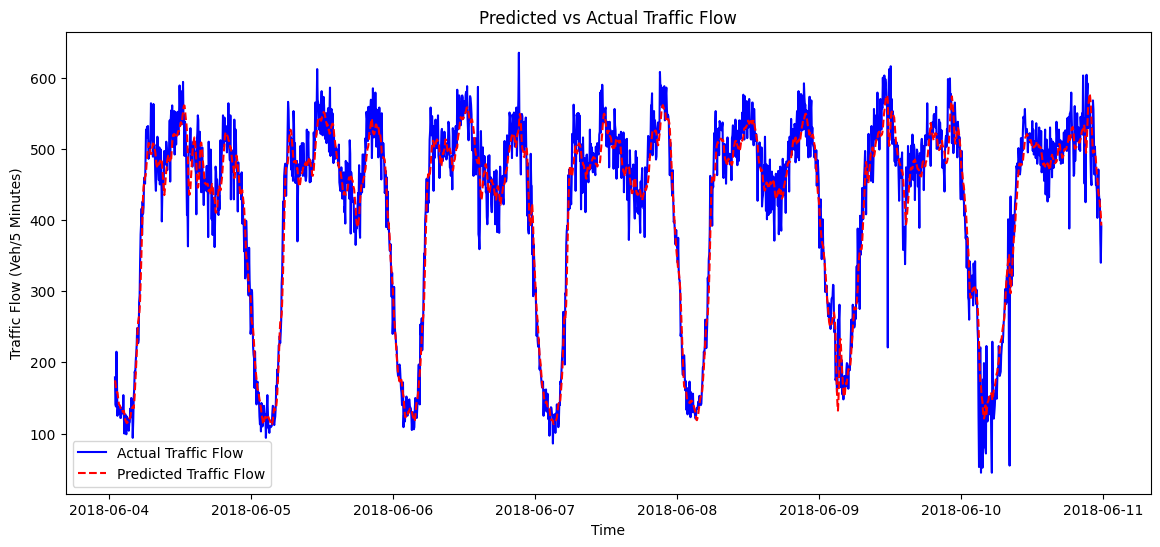

In [ ]:
# timestamps from validation set.
timestamps = test_flow.index[-len(y_test):]


# 287 timestamps in 1 day
plt.figure(figsize=(14, 6))
plt.plot(timestamps[:2000], y_test_rescaled[:2000, -1], label='Actual Traffic Flow', color='blue')
plt.plot(timestamps[:2000], y_pred_rescaled[:2000, -1], label='Predicted Traffic Flow', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Traffic Flow (Veh/5 Minutes)')
plt.title('Predicted vs Actual Traffic Flow')
plt.legend()
plt.show()
